In [171]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
sns.set_context('talk')
import panel as pn
import panel.widgets as pnw
pn.extension()
import geopandas as gpd
import json
import datetime as dt

In [369]:
pop = pd.read_csv('co-est2020.csv')
pop['county'] = pop.CTYNAME.apply(lambda x: ' '.join(x.split()[:-1]))
pop

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,POPESTIMATE2020,county
0,40,3,6,1,0,Alabama,Alabama,4921532,
1,50,3,6,1,1,Alabama,Autauga County,56145,Autauga
2,50,3,6,1,3,Alabama,Baldwin County,229287,Baldwin
3,50,3,6,1,5,Alabama,Barbour County,24589,Barbour
4,50,3,6,1,7,Alabama,Bibb County,22136,Bibb
...,...,...,...,...,...,...,...,...,...
3189,50,4,8,56,37,Wyoming,Sweetwater County,42673,Sweetwater
3190,50,4,8,56,39,Wyoming,Teton County,23497,Teton
3191,50,4,8,56,41,Wyoming,Uinta County,20215,Uinta
3192,50,4,8,56,43,Wyoming,Washakie County,7760,Washakie


In [382]:
df = pd.read_csv('us-counties.csv')
df['date'] = pd.to_datetime(df.date)
df=df.sort_values('date')
df['daily'] = df.groupby(['state','county'])['cases'].diff().fillna(0)
df['daily'] = df.daily.clip(lower=0)
df['daily'] = df.groupby(['state','county'])['daily'].transform(lambda x: x.rolling(24).mean()).fillna(0)
print (len(df))
#print (df[:4])
df = df.merge(pop,left_on=['county','state'],right_on=['county','STNAME'],how='left')
df['drate'] = (df.daily/df.POPESTIMATE2020)*1000
print (len(df))
#print (df[:4])
gdf = gpd.read_file('map_data/cb_2018_us_county_5m.shp')

1904345
1907966


<AxesSubplot:xlabel='date'>

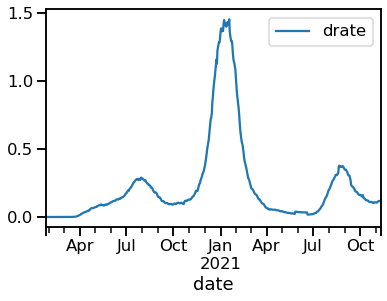

In [383]:
x = df[df.county=='Los Angeles']
#print (x)
x.plot(x='date',y='drate')

In [ ]:
print (df[:3])
print (gdf[:4])

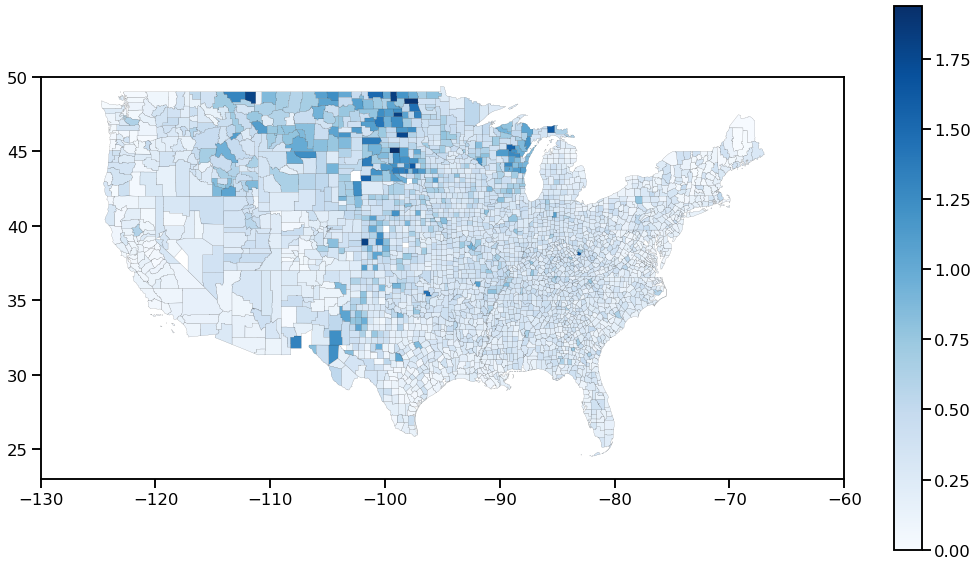

In [471]:
def plot_map(x, fig):
    """Plot map """
    plt.clf()    
    ax=fig.add_subplot(label='a')
    x.plot(column='drate',cmap='Blues',lw=.1,ec='black',ax=ax,legend=True)
    ax.set_xlim([-130,-60])
    ax.set_ylim(23,50)
    return

date='2021-09-05'
#sub = df[df.date==date].dropna()

sub = df[(df.date>'2020-11-01') & (df.date<'2020-11-07')].dropna()
sub = sub.groupby('county').mean()

sub=sub[sub.drate<2]
#print (sub.sort_values('deaths',ascending=False)[:5])
#print (len(sub))
x = gdf.merge(sub,left_on='NAME',right_on='county',how='right')
#print (sub.sort_values('dday',ascending=False)[:5])
fig=plt.figure(figsize=(18,10))
#fig,ax=plt.subplots(figsize=(18,10))
plot_map(x, fig)

In [ ]:
fig=plt.figure(figsize=(18,10))

#for date in df.date.unique()[:5]:
    


<Figure size 1296x720 with 0 Axes>

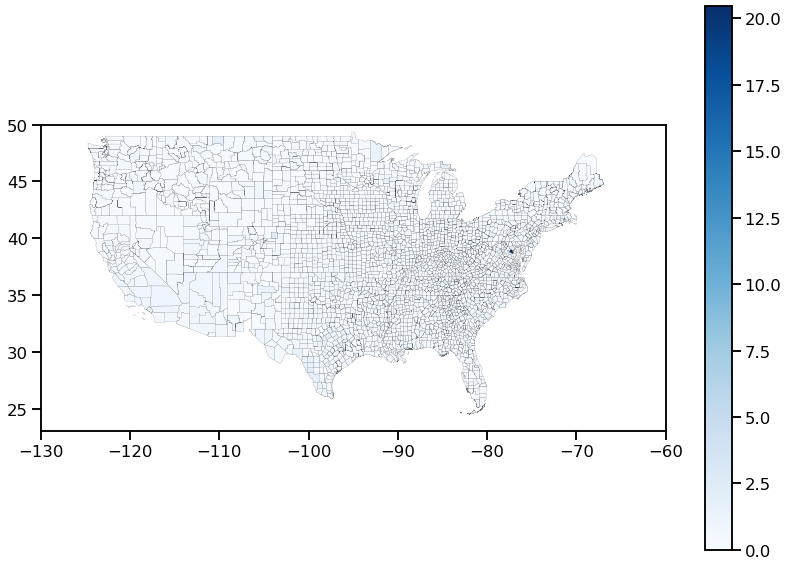

In [472]:
def dashboard():  
    
    #fig = plt.Figure(figsize=(14,6))
    fig,ax=plt.subplots(figsize=(14,10))
    map_pane=pn.pane.Matplotlib(width=1000)
    map_pane.object = fig
    date_picker = pnw.DatePicker(name='Pick Date',width=200)
    from datetime import date  
    date_picker.value=date(2020, 1, 1)
    date_slider = pnw.DateSlider(name='Date', start=dt.datetime(2020, 1, 1), 
                                 end=dt.datetime(2021, 10, 31), value=dt.datetime(2021, 1, 1))
    

    def update_map(event=None, date=None):        
        date = str(date_slider.value)
        sub = df[df.date==date]
        x = gdf.merge(sub,left_on='NAME',right_on='county',how='right')        
        plot_map(x,fig) 
        map_pane.param.trigger('object')    
        return
    
    sdate='2021-02-02'
    sub = df[df.date==sdate]
    x = gdf.merge(sub,left_on='NAME',right_on='county',how='right')    
    plot_map(x,fig) 
    date_slider.param.watch(update_map,'value')
    
    dashboard = pn.Column(date_slider,pn.Row(pn.Column(date_picker),map_pane))
    return dashboard

app=dashboard()


Column
    [0] DateSlider(end=datetime.datetime(2021, ..., name='Date', start=datetime.datetime(2020, ..., value=datetime.datetime(2021, ...)
    [1] Row
        [0] Column
            [0] DatePicker(name='Pick Date', value=datetime.date(2020, 1, 1), width=200)
        [1] Matplotlib(Figure, width=1000)
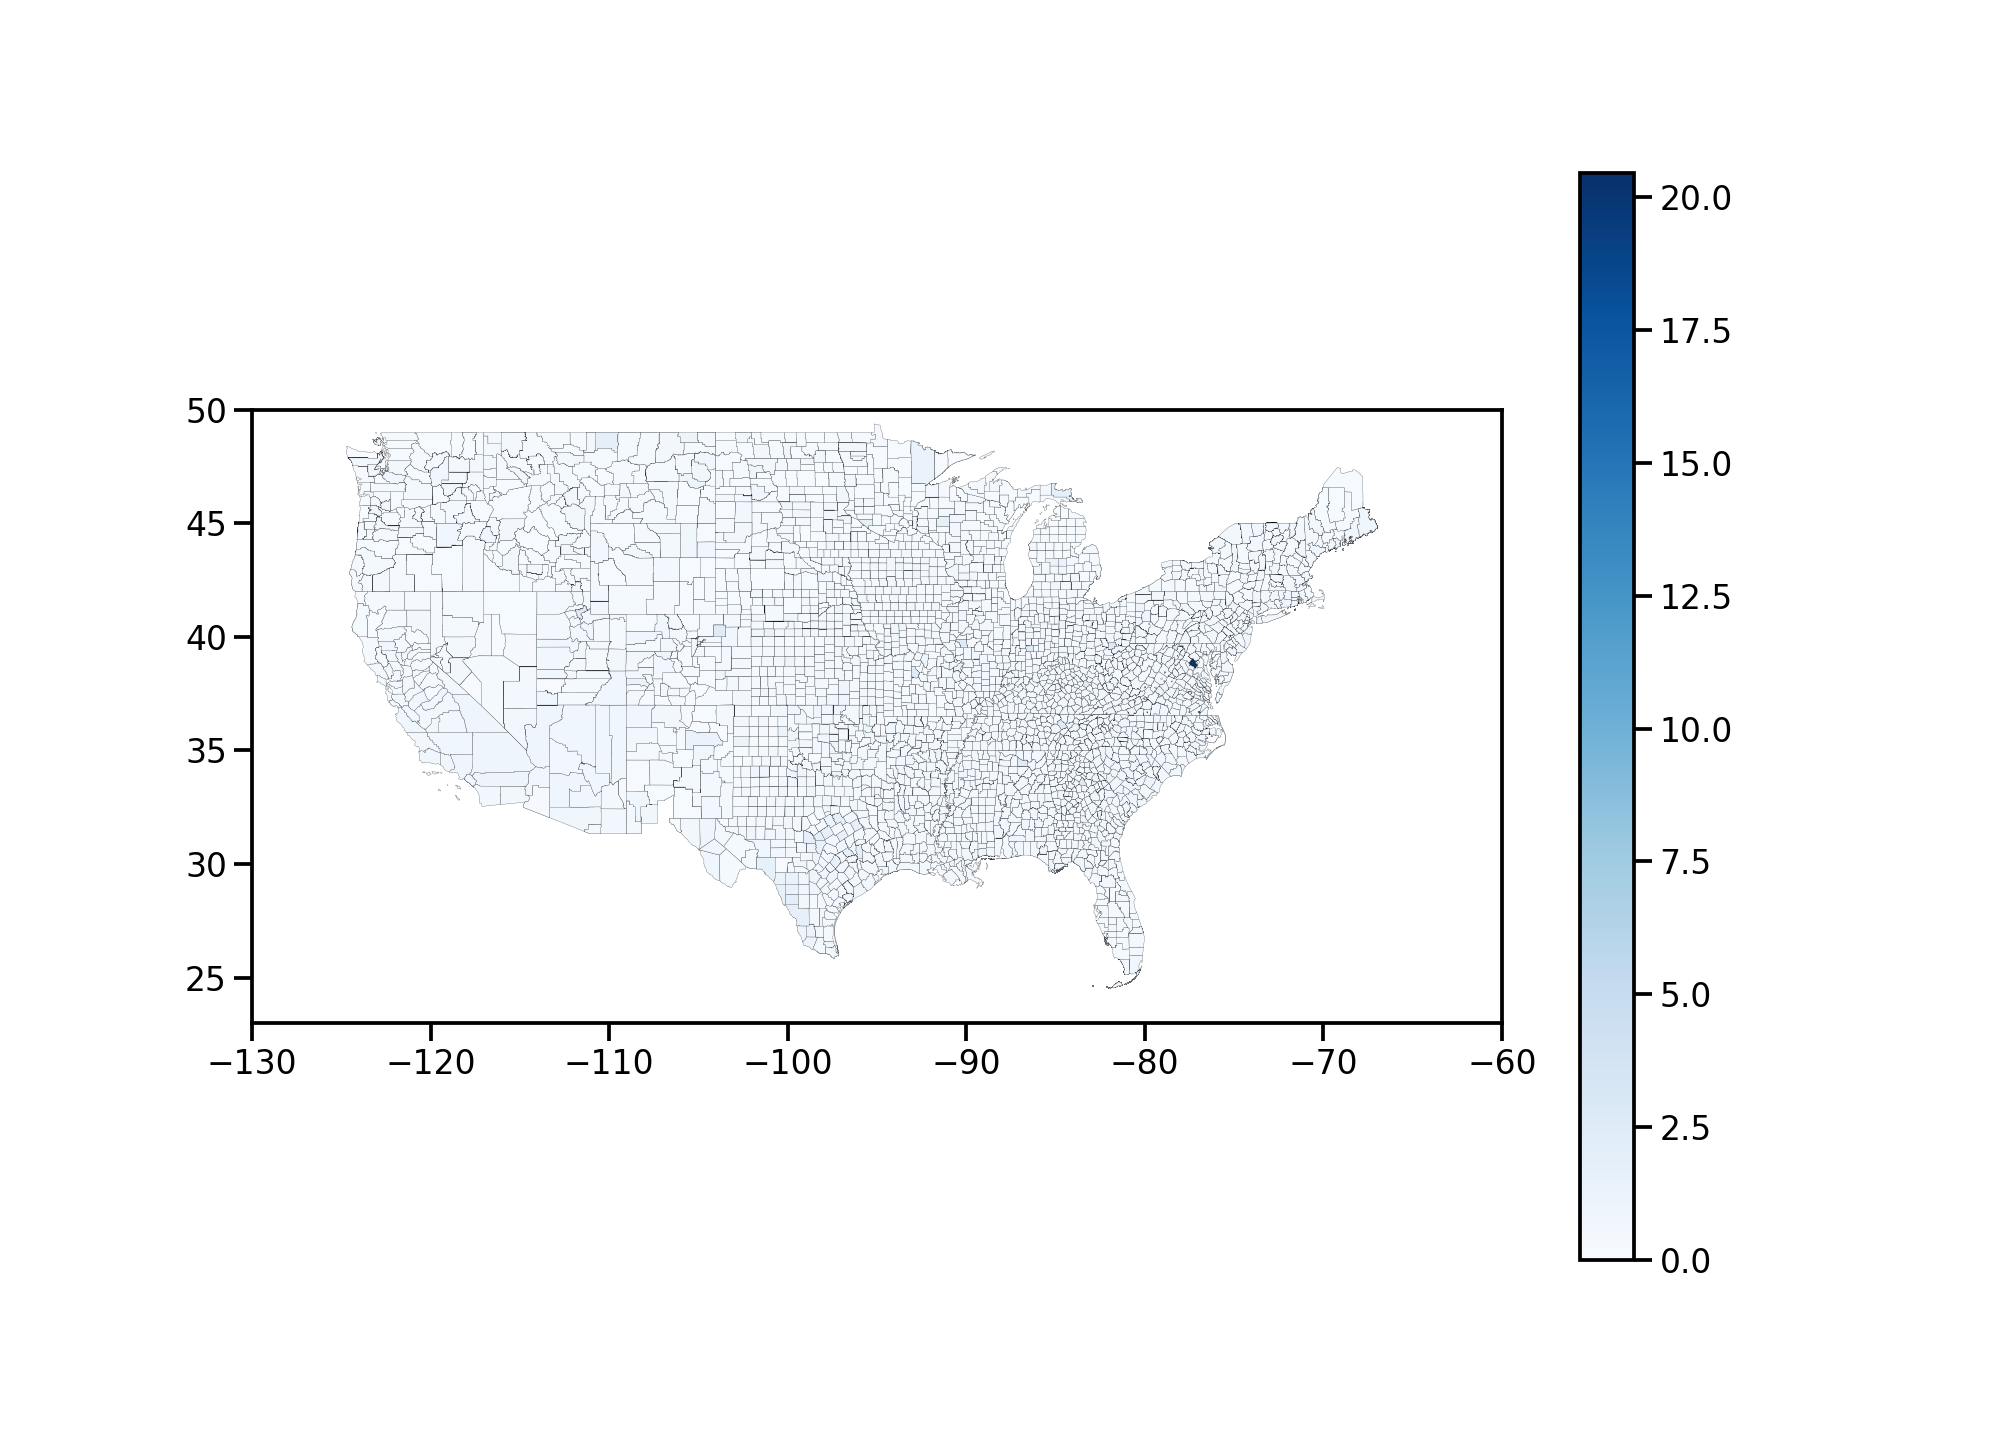

In [473]:
app